This notebook is a comparison of voltage profiles over time for DFN (Doyle-Fuller-Newman), SPMe (Single Particle with Electrolyte), SPM (Single Particle), and RM (Reservoir Model, uniform diffusion) models during the first full cycle. This is equivalent to Figure 2 in the manuscript.

In [1]:
import numpy as np
import pybamm

no_cycles = 1
exp = pybamm.Experiment(
    [("Charge at C/20 until 4.2 V",
      "Rest for 5 hours",
      "Discharge at C/20 until 2.5 V",
      "Rest for 5 hours",
      )]* no_cycles )

param=pybamm.ParameterValues("Chen2020")

models = [pybamm.lithium_ion.SPM({"particle": "uniform profile"}),
          pybamm.lithium_ion.SPM(),
          pybamm.lithium_ion.SPMe(),
          pybamm.lithium_ion.DFN(),
          ]
models_name = ["RM", "SPM", "SPMe", "DFN"]

solver = pybamm.CasadiSolver(mode="safe")
sims = [pybamm.Simulation(model, parameter_values=param,
                          experiment=exp, solver=solver) for model in models]
sols = [sim.solve(initial_soc=0) for sim in sims]

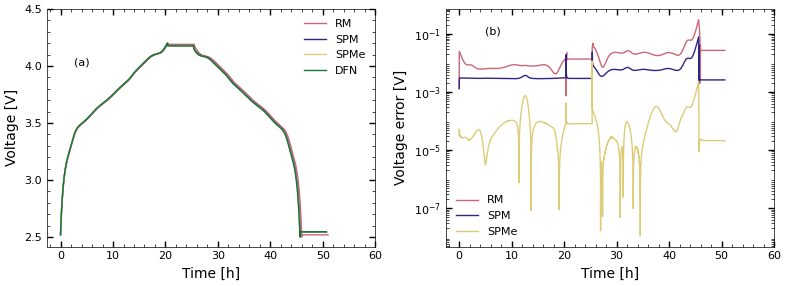

In [2]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from style_figs import set_plotting_format

set_plotting_format("paper")  # input should be either "presentation" or "paper"

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)


# First subplot
for index, model_name in enumerate(models_name):
    time = sols[index]["Time [h]"].entries
    voltage = sols[index]["Terminal voltage [V]"].entries
    axes[0].plot(time, voltage, label=model_name)

axes[0].legend()
axes[0].set_xlabel("Time [h]")
axes[0].set_ylabel("Voltage [V]")
axes[0].text(2.5, 4.0, "(a)")

# Set x-axis ticks and labels for the first subplot
xticks = np.arange(0, 70, 10)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xticks)

# Set y-axis ticks for the first subplot
yticks = np.arange(2.5, 5, 0.5)
axes[0].set_yticks(yticks)

# Second subplot
t_max = max(sol["Time [s]"].entries[-1] for sol in sols)
t = np.linspace(0, t_max, 10000)

for model_name in models_name[:-1]:  # Skip DFN
    index = models_name.index(model_name)
    error = sols[models_name.index("DFN")]["Terminal voltage [V]"](t) - sols[index]["Terminal voltage [V]"](t)
    axes[1].semilogy(t / 3600, np.abs(error), label=model_name)

axes[1].legend()
axes[1].set_xlabel("Time [h]")
axes[1].set_ylabel("Voltage error [V]")
axes[1].text(5, 1e-1, "(b)")

# Set x-axis ticks and labels for the second subplot
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xticks)

# Adjusting the number of ticks on the y-axis for the second subplot
axes[1].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=4))

plt.tight_layout()
plt.savefig("figs/models_comparison.png", dpi=300)